### Natural Language Processing with TF-IDF, GloVe, Vader and Logistic Regression
Twitter Outrage Machine (OM); Insight Project- Michele Waters

* It has been observed in popular culture that a large "Twitter ratio" (a ratio of Twitter comments/likes >1) is usually indicative that other Twitter users strongly disagree with a Twitter post. 



* Hypothesis: the "Twitter ratio" can be used as a metric of Twitter outrage/ significant negative sentiment, 



* Let's use the tweet text data we collected ('1_Scrape_Tweets_Tweepy.py'), cleaned ('2_Clean_CSV_to_SQL.py' & '4_Clean_Text_Label_Categories_Merge_Tables_Data_Manipulation.ipynb'), and scoped down & explored ('5_EDA_Clustering.ipynb') in combination with the user account infomation we collected ('3_Get_Twitter_User_Data_Twython_no_key.py') from 100+ Twitter accounts across governement, news, entertainment/sports, and industry to see if we can predict whether a tweet will be ratioed.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3

In [2]:
conn=sqlite3.connect('merged_tweets_2019_2020.db')
cursor= conn.cursor()

In [3]:
#Create function to query SQL data
def query_data(sql_statement):
    df=pd.read_sql(sql_statement, conn)
    #cursor.execute(sql_statement)
    return df.to_dict('records')

In [4]:
#Connect to database file with merged user account info/cleaned tweets and scoped data
df=pd.DataFrame(query_data('SELECT * FROM merged_twitter_data_gated'))

In [5]:
df.head()

,account_id,author_id,category,cleaned_text,cluster_labels,created_at,d_log_ratio,d_richter_like_ratio,d_richter_retweet_ratio,date,...,text,text_processed,to,tweet_id,url,url_attached,url_present,username,verified,year
0,813286,813286,1,true key moment history going depend young peo...,2,Mon Mar 05 22:08:25 +0000 2007,-3,-13.0,-6.0,2020-06-07 23:25:01+00:00,...,As has always been true at key moments in hist...,as has always been true at key moments in his...,None,1269772382509596677,https://t.co/93Y27HEnnX,https://www.obama.org/updates/president-obama-...,1,barackobama,1,2020
1,813286,813286,1,seen power voice speak injustice know toll tak...,2,Mon Mar 05 22:08:25 +0000 2007,-3,-12.0,-6.0,2020-06-06 00:37:08+00:00,...,We’ve seen the power that our voices have when...,we have seen the power that our voices have w...,ObamaFoundation,1269065755179524096,https://t.co/93Y27HEnnX,https://twitter.com/ObamaFoundation/status/126...,1,barackobama,1,2020
2,813286,813286,1,national gun violence awareness day wearorange...,2,Mon Mar 05 22:08:25 +0000 2007,-2,-12.0,-4.0,2020-06-05 16:21:00+00:00,...,"On National Gun Violence Awareness Day, we #We...",on national gun violence awareness day we w...,None,1268940899616243715,https://t.co/93Y27HEnnX,None,0,barackobama,1,2020
3,813286,813286,1,city country mbk alliance community city count...,2,Mon Mar 05 22:08:25 +0000 2007,-3,-11.0,-6.0,2020-06-04 23:15:58+00:00,...,"Third, every city in this country should be a ...",third every city in this country should be a...,None,1268682939799425024,https://t.co/93Y27HEnnX,http://obama.org/mbka/about-mbk-communities,1,barackobama,1,2020
4,813286,813286,1,second mayor review use force policy member co...,2,Mon Mar 05 22:08:25 +0000 2007,-3,-12.0,-6.0,2020-06-04 23:15:58+00:00,...,"Second, every mayor should review their use of...",second every mayor should review their use o...,None,1268682938251710464,https://t.co/93Y27HEnnX,http://obama.org/mayor-pledge,1,barackobama,1,2020


In [6]:
df.columns

Index(['account_id', 'author_id', 'category', 'cleaned_text', 'cluster_labels',
       'created_at', 'd_log_ratio', 'd_richter_like_ratio',
       'd_richter_retweet_ratio', 'date', 'description', 'doy',
       'encoded_hashtag', 'encoded_urls', 'favorites', 'favourites_count',
       'followers_count', 'formatted_date', 'friends_count', 'got_ratioed',
       'got_richter_ratioed', 'hashtag_present', 'hashtags', 'hour', 'id',
       'link_to_tweet', 'listed_count', 'location', 'log_ratio', 'minute',
       'name', 'num_hashtags', 'ratio_comment_like', 'ratio_comment_retweet',
       'ratio_richter_likes', 'ratio_richter_retweets', 'ratio_target',
       'reply_count', 'reply_to', 'retweets', 'second', 'statuses_count',
       'text', 'text_processed', 'to', 'tweet_id', 'url', 'url_attached',
       'url_present', 'username', 'verified', 'year'],
      dtype='object')

In [7]:
#Numeric columns
df.select_dtypes('number').columns

Index(['account_id', 'author_id', 'cluster_labels', 'd_log_ratio',
       'd_richter_like_ratio', 'd_richter_retweet_ratio', 'doy',
       'encoded_hashtag', 'encoded_urls', 'favorites', 'favourites_count',
       'followers_count', 'friends_count', 'got_ratioed',
       'got_richter_ratioed', 'hashtag_present', 'hour', 'id', 'listed_count',
       'log_ratio', 'minute', 'num_hashtags', 'ratio_comment_like',
       'ratio_comment_retweet', 'ratio_richter_likes',
       'ratio_richter_retweets', 'ratio_target', 'reply_count', 'retweets',
       'second', 'statuses_count', 'tweet_id', 'url_present', 'verified',
       'year'],
      dtype='object')

In [9]:
df.select_dtypes('O').columns

Index(['category', 'cleaned_text', 'created_at', 'date', 'description',
       'formatted_date', 'hashtags', 'link_to_tweet', 'location', 'name',
       'reply_to', 'text', 'text_processed', 'to', 'url', 'url_attached',
       'username'],
      dtype='object')

In [10]:
df.category=df.category.astype('int64')

* Our original tweets are in the 'text' column, while our cleaned (tokenized, lemmatized) text data is in the 'cleaned_text' column of df

In [11]:
#Original tweet
df['text'][0]

'As has always been true at key moments in history, it’s going to depend on young people to go out there and rewrite what is possible. I couldn’t be prouder of all the young people leading that change right now. Here’s my advice for the Class of 2020:'

Despite there being no NaN values in the text data, I still discovered some missing text data that needed to be removed. Let's get the indices of these missing values:

In [12]:
#All data: 249716 rows × 1 columns
#Missing values: 12783 rows × 1 columns 
#df[['cleaned_text']][df['cleaned_text']==''].index

In [180]:
df=df.drop(index=df[['cleaned_text']][df['cleaned_text']==''].index)

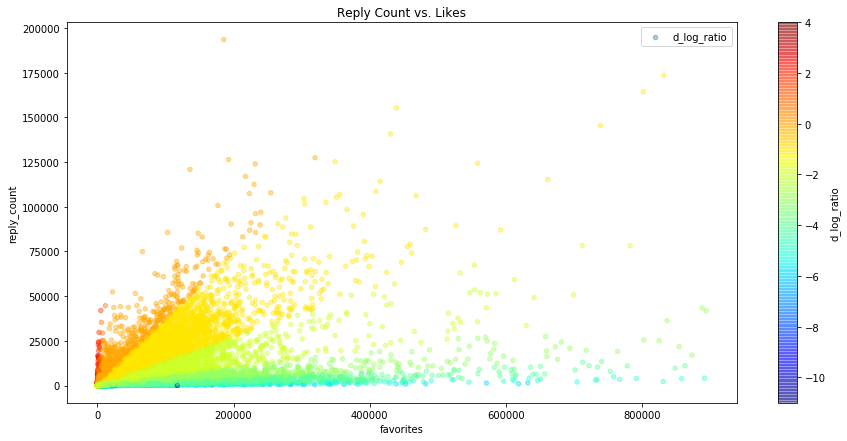

In [181]:
#Look at discrete values for log ratio score using matplotlib
fig, ax = plt.subplots()
df.plot(kind="scatter", x="favorites", y="reply_count", alpha=0.4,
            label='d_log_ratio',
            c='d_log_ratio', cmap=plt.get_cmap("jet"), colorbar=True,
            figsize=(15,7), title='Reply Count vs. Likes', ax=ax)
plt.legend()
plt.show()

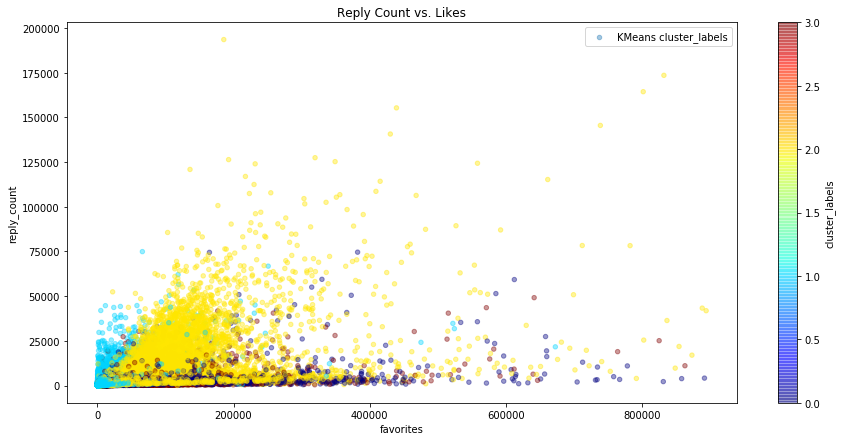

In [182]:
#Look at distribution of KMeans Clusters
fig, ax = plt.subplots()
df.plot(kind="scatter", x="favorites", y="reply_count", alpha=0.4,
            label='KMeans cluster_labels',
            c='cluster_labels', cmap=plt.get_cmap("jet"), colorbar=True,
            figsize=(15,7), title='Reply Count vs. Likes', ax=ax)
plt.legend()
plt.show()

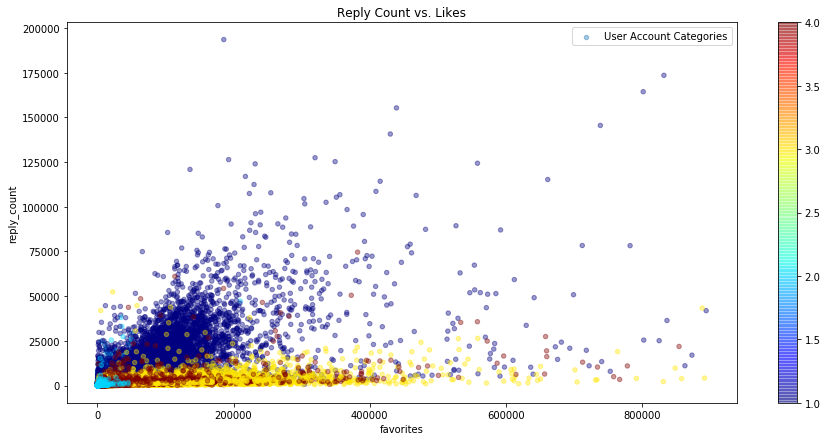

In [183]:
#Look at distribution of user account categories
cats=df.category.astype('int')
fig, ax = plt.subplots()
df.plot(kind="scatter", x="favorites", y="reply_count", alpha=0.4,
            label='User Account Categories',
            c=cats, cmap=plt.get_cmap("jet"), colorbar=True,
            figsize=(15,7), title='Reply Count vs. Likes', ax=ax)
plt.legend()
plt.show()

* Distribution of log ratio score, (i.e. log(Twitter replies/Twitter likes))

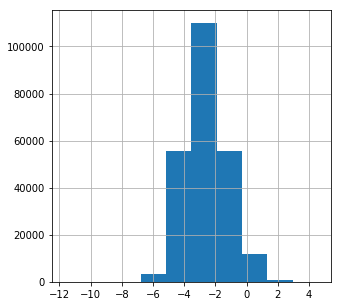

In [184]:
#Distribution of log ratio score
fig = plt.figure(figsize = (5,5))
ax = fig.gca()
df.log_ratio.hist(ax=ax)
plt.show()

* Previously, we cleaned our data by removing tweets with 0 likes/retweets/replies


* We also further scoped our data by removing tweets with less than 50 replies and by removing outliers (removing tweets with more than $0.9*10^6$  likes and more than $0.3*10^6$ retweets)


* We made our log ratio score discrete, and created the target column 'ratio_target', which is equal to 1 where the discrete log ratio>0 and 0 elsewhere. We will use this as our metric for whether a tweet has been ratioed or not.

In [185]:
df.ratio_target.unique()

array([0, 1])

In [186]:
df.ratio_target.value_counts()

0    235561
1      1372
Name: ratio_target, dtype: int64

In [187]:
#Select features for clustering; cluster labels was calculated in Jupyter Notebook 5 (EDA file)
selected_features=['cleaned_text', 'followers_count','friends_count', 'listed_count', 'favourites_count', 'statuses_count',
                   'doy', 'year', 'hour', 'minute', 'second', 'encoded_urls',
                   'url_present', 'encoded_hashtag', 'hashtag_present', 'num_hashtags', 'category', 'ratio_target']

In [188]:
#Selected features
selected_df=df[selected_features]

In [189]:
selected_df.head()

,cleaned_text,followers_count,friends_count,listed_count,favourites_count,statuses_count,doy,year,hour,minute,second,encoded_urls,url_present,encoded_hashtag,hashtag_present,num_hashtags,category,ratio_target
0,true key moment history going depend young peo...,119658056,604838,220889,5,15843,159,2020,23,25,1,60582,1,0,0,0,1,0
1,seen power voice speak injustice know toll tak...,119658056,604838,220889,5,15843,158,2020,0,37,8,49129,1,0,0,0,1,0
2,national gun violence awareness day wearorange...,119658056,604838,220889,5,15843,157,2020,16,21,0,0,0,7251,1,1,1,0
3,city country mbk alliance community city count...,119658056,604838,220889,5,15843,156,2020,23,15,58,14350,1,0,0,0,1,0
4,second mayor review use force policy member co...,119658056,604838,220889,5,15843,156,2020,23,15,58,14349,1,0,0,0,1,0


In [190]:
#Cleaned tweet
selected_df['cleaned_text'][0]

'true key moment history going depend young people rewrite possible prouder young people leading change right advice class'

In [191]:
#double check there are no NaN values
selected_df['cleaned_text'].isna().sum()

0

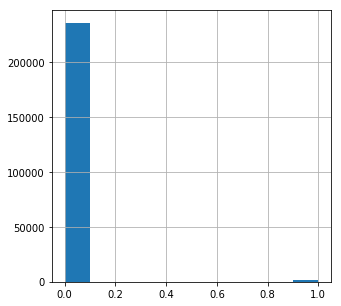

In [192]:
#Distribution of ratio (1) and non-ratio (0)
fig = plt.figure(figsize = (5,5))
ax = fig.gca()
selected_df.ratio_target.hist(ax=ax)
plt.show()

In [193]:
#Assign ratio_target to target variable
target=df.ratio_target

In [194]:
target.value_counts()

0    235561
1      1372
Name: ratio_target, dtype: int64

* Twitter ratios now only make up 0.58% of our dataset. Therefore, we will use strategies to correct for this imbalance in our models, such as undersampling the majority (non-ratio) class.

In [195]:
#Twitter ratios in data
(1372/235561)*100

0.5824393681466796

### Word Coud

* Let's see what the cleaned text looks like:

Update: Despite there being no NaN values in the text data, I still discovered some missing text data that needed to be removed. Let's get the indices of these missing values:

In [196]:
#All data: 249716 rows × 1 columns
#Missing values: 12783 rows × 1 columns 
df[['cleaned_text']][df['cleaned_text']==''].index

Int64Index([], dtype='int64')

In [197]:
df=df.drop(index=df[['cleaned_text']][df['cleaned_text']==''].index)

In [198]:
#!pip install wordcloud

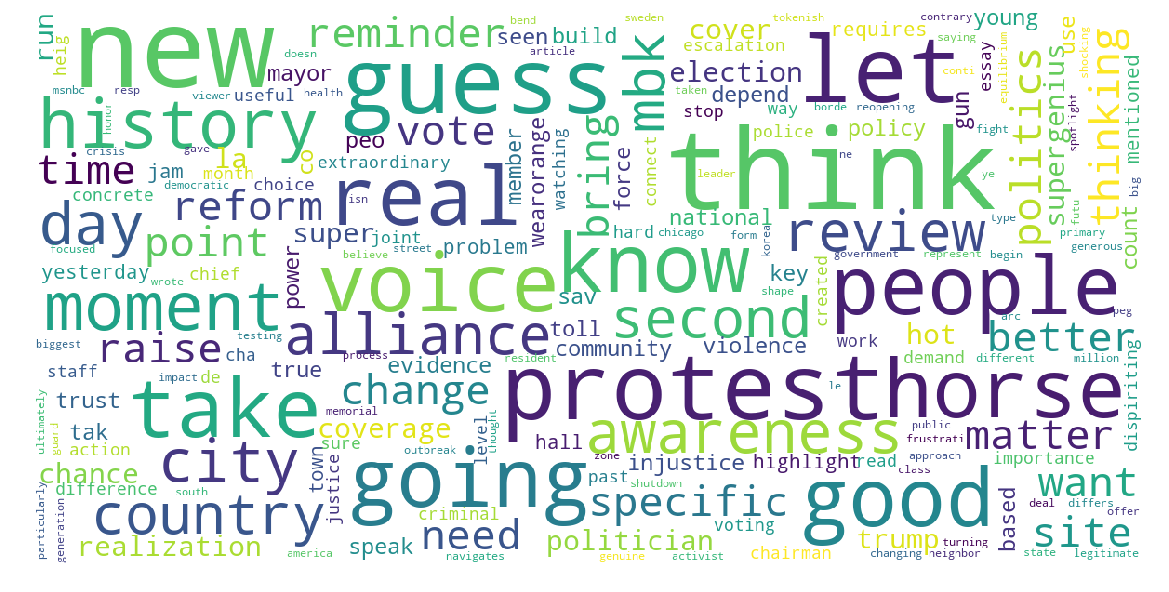

In [199]:
# wordcloud function

from wordcloud import WordCloud

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(selected_df['cleaned_text'])

* Let's also look at the word clouds for ratio vs. non-ratio

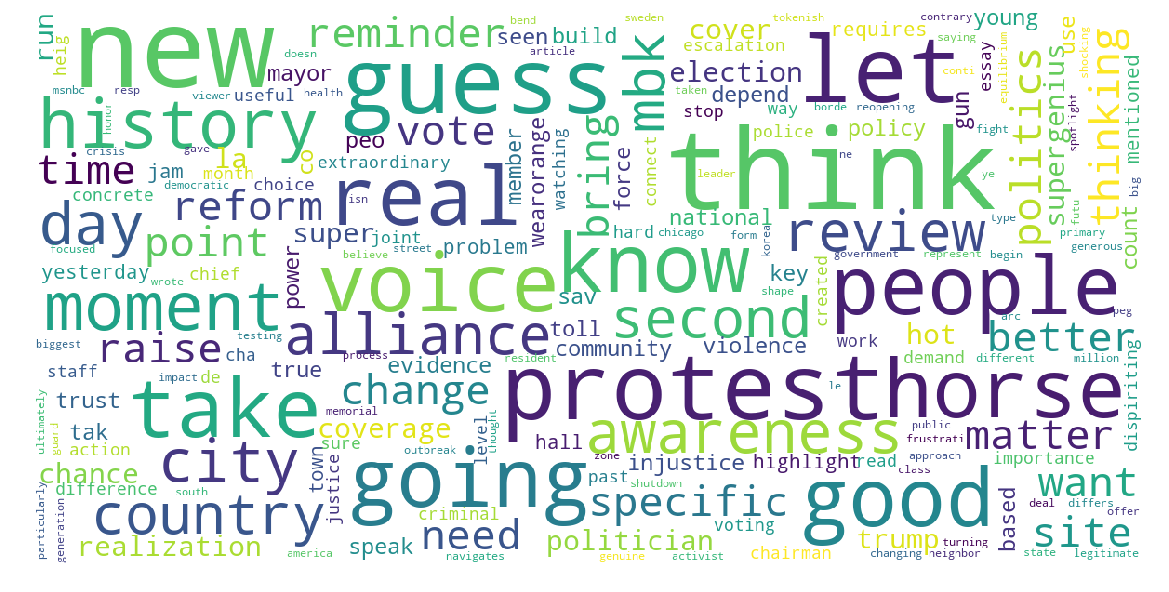

In [200]:
# Non-ratio word cloud
show_wordcloud(selected_df[selected_df.ratio_target==0]['cleaned_text'])

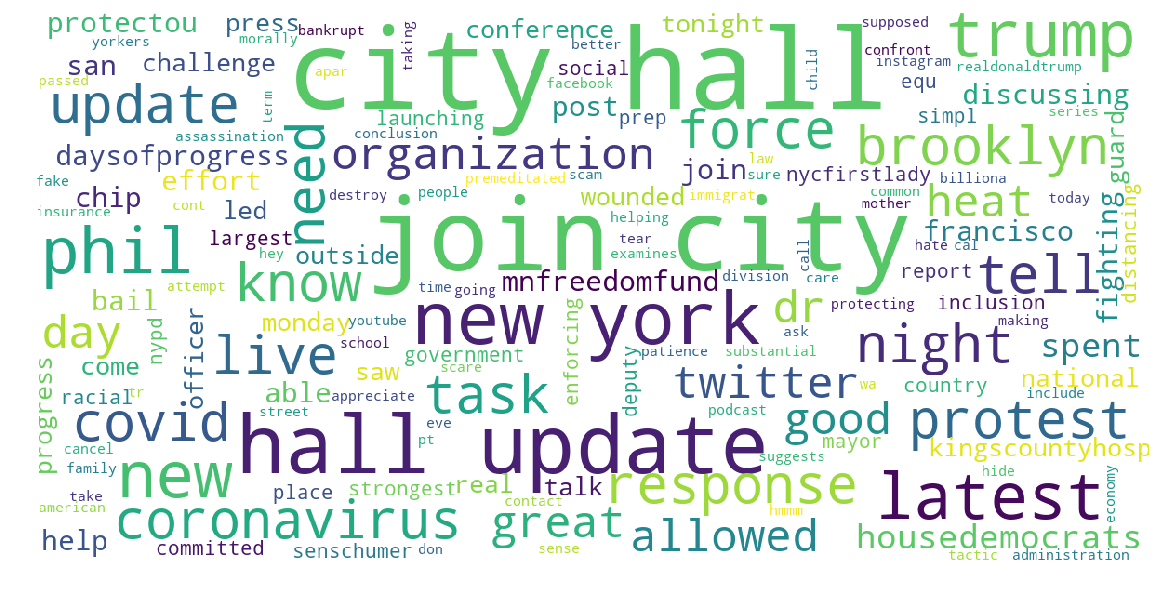

In [201]:
# Ratio word cloud
show_wordcloud(selected_df[selected_df.ratio_target==1]['cleaned_text'])

* Many of the words in the 'ratio' word cloud appear to be political

### Underdampling Strategy

* Since ratios represent only a small portion of our data, let's undersample the majority (non-ratio class) so that we have a balanced dataset.

In [36]:
!pip install imblearn

     |████████████████████████████████| 174kB 14.8MB/s eta 0:00:01
     |████████████████████████████████| 6.9MB 28.3MB/s eta 0:00:01
  Found existing installation: scikit-learn 0.22.1
    Uninstalling scikit-learn-0.22.1:
      Successfully uninstalled scikit-learn-0.22.1
You should consider upgrading via the 'pip install --upgrade pip' command.


In [202]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

In [203]:
# define undersample strategy & drop target column from features
undersample = RandomUnderSampler(sampling_strategy='majority')

features_under, labels_under = undersample.fit_resample(selected_df.drop(columns='ratio_target'), selected_df['ratio_target'])

X_train, X_validate, y_train, y_validate= train_test_split(features_under, labels_under, stratify=labels_under, random_state=1)

In [204]:
X_train.shape, X_validate.shape

((2058, 17), (686, 17))

In [205]:
X_train.head()

,cleaned_text,followers_count,friends_count,listed_count,favourites_count,statuses_count,doy,year,hour,minute,second,encoded_urls,url_present,encoded_hashtag,hashtag_present,num_hashtags,category
1762,s solid reporting trump russia mystery medium ...,716116,6881,13700,264356,197664,84,2019,11,54,0,5874,1,0,0,0,2
87,know happen assured britain join euro disaster...,7600537,1995,17519,6,135953,8,2019,21,14,10,52579,1,0,0,0,2
1227,dow point news representative seth moulton dro...,82060029,46,115218,4,52803,235,2019,19,1,20,0,0,0,0,0,1
2168,blame trump hate speech triggering violence la...,1367420,115,8915,969,128887,216,2019,0,56,30,42135,1,0,0,0,2
1650,president trump took dancing competition serio...,716116,6881,13700,264356,197664,316,2019,11,55,7,59211,1,0,0,0,2


Be mindful, the original sample indices have been rearanged. But now we have an even number of ratios in our training and validation sets, and ratios make up ~50% of each data set:

In [206]:
features_under.cleaned_text.loc[1227]

'dow point news representative seth moulton dropped presidential race'

In [207]:
selected_df.cleaned_text.loc[1227]

'light clear evidence russia interfered election past seek s inexcusable administration downsizing dhs task force charged protecting election foreign influence'

In [208]:
df.text.loc[1227]

"In light of clear evidence that Russia has interfered with our elections in the past and seeks to do so again, it's inexcusable that the administration is downsizing DHS task forces charged with protecting our elections from foreign influence."

In [209]:
#Ratios make up 50% of dataset
y_train.mean(), y_validate.mean()

(0.5, 0.5)

In [210]:
#Total number of ratios in training/validation sets
y_train.sum(), y_validate.sum()

(1029, 343)

### TF-IDF

* Since ratios represent only a small portion of our data, let's start by using TF-IDF to try to surface rare words that may be highly correlated to ratios


* Term frequency–inverse document frequency-- a numerical statistic intended to reflect how important a word is to a document in a collection/corpus.

In [211]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

vect = TfidfVectorizer()
tfidf_matrix_train = vect.fit_transform(X_train['cleaned_text'])
tfidf_df_train = pd.DataFrame(tfidf_matrix_train.toarray(), columns = vect.get_feature_names(), index=X_train.index)
tfidf_matrix_val = vect.transform(X_validate['cleaned_text'])
tfidf_df_val = pd.DataFrame(tfidf_matrix_val.toarray(), columns = vect.get_feature_names(), index=X_validate.index)
tfidf_df_train.head()

,aa,aaron,aarpmaine,abc,abdul,abiding,ability,abita,able,abortion,...,zink,zkkzljwnaajv,znev,zone,zoua,zrqv,zsayl,zucker,zvrr,zymj
1762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Logistic Regression is appropriate for our binary target (ratio v. non-ratio). To start, let's only use text data for our features 

In [212]:
from sklearn.linear_model import LogisticRegression

In [213]:
clf = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
clf.fit(tfidf_df_train, y_train)
print(clf.score(tfidf_df_val, y_validate))

0.7099125364431487


Let's also look at Precision and Recall

In [214]:
from sklearn import metrics

In [215]:
# Predicting with a test dataset
best_predict=clf.predict(tfidf_df_val)
# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_validate, pd.Series(best_predict)))
print("Logistic Regression Precision:",metrics.precision_score(y_validate, pd.Series(best_predict)))
print("Logistic Regression Recall:",metrics.recall_score(y_validate, pd.Series(best_predict)))

Logistic Regression Accuracy: 0.7099125364431487
Logistic Regression Precision: 0.702247191011236
Logistic Regression Recall: 0.7288629737609329


Let's look at the top 50 features of our TF-IDF model

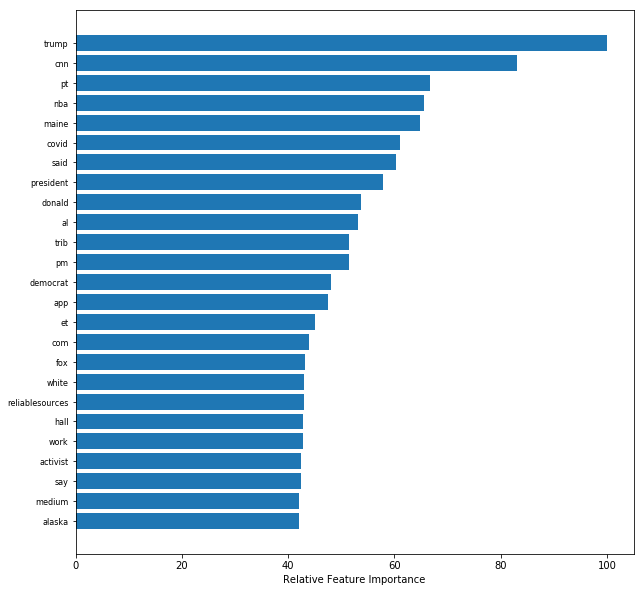

In [358]:
#Top 50 features from TF-IDF
feature_importance = abs(clf.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max()) #convert importance to percentage
sorted_idx = np.argsort(feature_importance)[::-1][:25][::-1]
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(10,10))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(pd.DataFrame(tfidf_df_val).columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')
plt.show()

Let's see if we can improve our score by adding in the user account information, but let's scale the account data

In [217]:
from sklearn.preprocessing import StandardScaler

In [218]:
num_features_under=features_under.drop(columns='cleaned_text')

In [219]:
num_features_under.columns

Index(['followers_count', 'friends_count', 'listed_count', 'favourites_count',
       'statuses_count', 'doy', 'year', 'hour', 'minute', 'second',
       'encoded_urls', 'url_present', 'encoded_hashtag', 'hashtag_present',
       'num_hashtags', 'category'],
      dtype='object')

In [220]:
#Continuous features for scaling
scale_features=['followers_count', 'friends_count', 'listed_count', 'favourites_count',
       'statuses_count', 'doy', 'year', 'hour', 'minute', 'second',
       'encoded_urls', 'encoded_hashtag', 'num_hashtags']

In [221]:
non_scale_features= [col for col in num_features_under.columns if col not in scale_features]
non_scale_features

['url_present', 'hashtag_present', 'category']

In [222]:
scale=StandardScaler()
scaled_features_under=pd.DataFrame(scale.fit_transform(num_features_under[scale_features]), columns=scale_features, index=num_features_under.index)
scaled_features_under=pd.concat([scaled_features_under, num_features_under[non_scale_features]], axis=1)
scaled_features_under.head()

,followers_count,friends_count,listed_count,favourites_count,statuses_count,doy,year,hour,minute,second,encoded_urls,encoded_hashtag,num_hashtags,url_present,hashtag_present,category
0,-0.237881,-0.129188,0.064289,-0.329380,-1.015731,1.285653,-0.747132,1.127564,0.105039,0.459813,-0.977065,-0.415020,-0.437681,0,0,3
1,-0.106922,-0.162812,-0.031708,-0.357724,-1.158777,1.656243,-0.747132,-1.742979,1.231809,0.066787,-0.977065,0.559704,1.148841,0,1,1
2,1.075090,0.011335,1.256784,-0.335095,1.381189,1.373424,-0.747132,1.264256,-0.007638,-1.449171,-0.977065,4.023892,4.321887,0,1,4
3,4.573057,-0.161501,4.147256,-0.357905,-0.560831,-0.118688,-0.747132,0.444101,-1.303423,-0.157800,1.063559,-0.415020,-0.437681,1,0,1
4,-0.396209,-0.154226,-0.478045,-0.352527,-0.377182,-0.742840,-0.747132,-1.879672,-0.683700,0.684399,-0.977065,-0.415020,-0.437681,0,0,2


In [223]:
scaled_features_under.loc[X_train.index].head()

,followers_count,friends_count,listed_count,favourites_count,statuses_count,doy,year,hour,minute,second,encoded_urls,encoded_hashtag,num_hashtags,url_present,hashtag_present,category
1762,-0.444248,0.286484,-0.187917,3.068190,1.248937,-0.694078,-0.747132,-0.376054,1.457163,-1.561464,-0.719675,-0.41502,-0.437681,1,0,2
87,-0.019616,-0.033758,-0.024833,-0.357879,0.477973,-1.435258,-0.747132,0.990871,-0.796376,-0.999998,1.326864,-0.41502,-0.437681,1,0,2
1227,4.573057,-0.161501,4.147256,-0.357905,-0.560831,0.778530,-0.747132,0.717486,-1.528777,-0.438533,-0.977065,-0.41502,-0.437681,0,0,1
2168,-0.404076,-0.156979,-0.392254,-0.345399,0.389697,0.593235,-0.747132,-1.879672,1.569840,0.122933,0.869224,-0.41502,-0.437681,1,0,2
1650,-0.444248,0.286484,-0.187917,3.068190,1.248937,1.568472,-0.747132,-0.376054,1.513501,-1.168438,1.617468,-0.41502,-0.437681,1,0,2


In [224]:
merged_train_df=pd.concat([scaled_features_under.loc[X_train.index], tfidf_df_train], axis=1)
merged_train_df.head()

,followers_count,friends_count,listed_count,favourites_count,statuses_count,doy,year,hour,minute,second,...,zink,zkkzljwnaajv,znev,zone,zoua,zrqv,zsayl,zucker,zvrr,zymj
1762,-0.444248,0.286484,-0.187917,3.068190,1.248937,-0.694078,-0.747132,-0.376054,1.457163,-1.561464,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87,-0.019616,-0.033758,-0.024833,-0.357879,0.477973,-1.435258,-0.747132,0.990871,-0.796376,-0.999998,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1227,4.573057,-0.161501,4.147256,-0.357905,-0.560831,0.778530,-0.747132,0.717486,-1.528777,-0.438533,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2168,-0.404076,-0.156979,-0.392254,-0.345399,0.389697,0.593235,-0.747132,-1.879672,1.569840,0.122933,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1650,-0.444248,0.286484,-0.187917,3.068190,1.248937,1.568472,-0.747132,-0.376054,1.513501,-1.168438,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [225]:
merged_val_df=pd.concat([scaled_features_under.loc[X_validate.index], tfidf_df_val], axis=1)
merged_val_df.head()

,followers_count,friends_count,listed_count,favourites_count,statuses_count,doy,year,hour,minute,second,...,zink,zkkzljwnaajv,znev,zone,zoua,zrqv,zsayl,zucker,zvrr,zymj
1370,-0.019616,-0.033758,-0.024833,-0.357879,0.477973,0.105616,-0.747132,0.990871,0.443070,-1.505317,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
681,-0.019616,-0.033758,-0.024833,-0.357879,0.477973,-0.596554,-0.747132,-0.922824,-1.359761,-0.943852,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2556,-0.486038,-0.157634,-0.756258,-0.357387,-1.212560,-0.294231,1.338452,0.307409,0.950116,-0.101653,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
606,1.727294,-0.158683,1.514799,-0.282943,-1.079895,-0.255221,-0.747132,1.127564,-1.303423,-0.382386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109,1.075090,0.011335,1.256784,-0.335095,1.381189,0.934568,-0.747132,0.444101,-0.683700,1.526598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Logistic Regression with account features and TF-IDF

In [226]:
clf2 = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
clf2.fit(merged_train_df, y_train)
print(clf2.score(merged_val_df, y_validate))

0.8381924198250729


In [227]:
#Predicting with a validation dataset
best_predict2=clf2.predict(merged_val_df)
# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_validate, pd.Series(best_predict2)))
print("Logistic Regression Precision:",metrics.precision_score(y_validate, pd.Series(best_predict2)))
print("Logistic Regression Recall:",metrics.recall_score(y_validate, pd.Series(best_predict2)))
print("Logistic Regression F1 Score:",metrics.f1_score(y_validate, pd.Series(best_predict2)))

Logistic Regression Accuracy: 0.8381924198250729
Logistic Regression Precision: 0.7815533980582524
Logistic Regression Recall: 0.9387755102040817
Logistic Regression F1 Score: 0.8529801324503311


In [228]:
tfidf_df_train.head()

,aa,aaron,aarpmaine,abc,abdul,abiding,ability,abita,able,abortion,...,zink,zkkzljwnaajv,znev,zone,zoua,zrqv,zsayl,zucker,zvrr,zymj
1762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Alternatively, instead of combining the TF-IDF Matrix with the user account info matrix, let's see if we can stack the TFIDF model and use the account info to predict the residuals.

In [229]:
clf.predict_proba(tfidf_df_train)

array([[0.29498831, 0.70501169],
       [0.61158975, 0.38841025],
       [0.56323489, 0.43676511],
       ...,
       [0.35387148, 0.64612852],
       [0.39508707, 0.60491293],
       [0.62561346, 0.37438654]])

In [230]:
def residuals(clf=clf, X=tfidf_df_train, y=y_train):
    resid=[]
    probability_1= [val[1] for val in clf.predict_proba(X)]
    j=0 
    for i in y.index:
        if y[i]==1:
            resid.append(1-probability_1[j])
        else:
            resid.append(-1*probability_1[j])
        j+=1
    return resid

In [231]:
resid_train=residuals()
resid_train[:3]

[0.29498831376709567, -0.3884102470235826, -0.43676510729378704]

In [232]:
resid_val=residuals(X=tfidf_df_val, y=y_validate)
resid_val[:3]

[-0.3014561727492661, -0.3303026642345438, 0.6045392358603232]

In [233]:
account_train=scaled_features_under.loc[X_train.index]
account_val=scaled_features_under.loc[X_validate.index]

In [234]:
account_train.head()

,followers_count,friends_count,listed_count,favourites_count,statuses_count,doy,year,hour,minute,second,encoded_urls,encoded_hashtag,num_hashtags,url_present,hashtag_present,category
1762,-0.444248,0.286484,-0.187917,3.068190,1.248937,-0.694078,-0.747132,-0.376054,1.457163,-1.561464,-0.719675,-0.41502,-0.437681,1,0,2
87,-0.019616,-0.033758,-0.024833,-0.357879,0.477973,-1.435258,-0.747132,0.990871,-0.796376,-0.999998,1.326864,-0.41502,-0.437681,1,0,2
1227,4.573057,-0.161501,4.147256,-0.357905,-0.560831,0.778530,-0.747132,0.717486,-1.528777,-0.438533,-0.977065,-0.41502,-0.437681,0,0,1
2168,-0.404076,-0.156979,-0.392254,-0.345399,0.389697,0.593235,-0.747132,-1.879672,1.569840,0.122933,0.869224,-0.41502,-0.437681,1,0,2
1650,-0.444248,0.286484,-0.187917,3.068190,1.248937,1.568472,-0.747132,-0.376054,1.513501,-1.168438,1.617468,-0.41502,-0.437681,1,0,2


In [235]:
len(account_val.columns)

16

In [236]:
from sklearn.ensemble import RandomForestRegressor

In [237]:
account_rf=RandomForestRegressor(random_state=42).fit(account_train, resid_train)

In [238]:
account_rf.score(account_val, resid_val)

0.3988106893497855

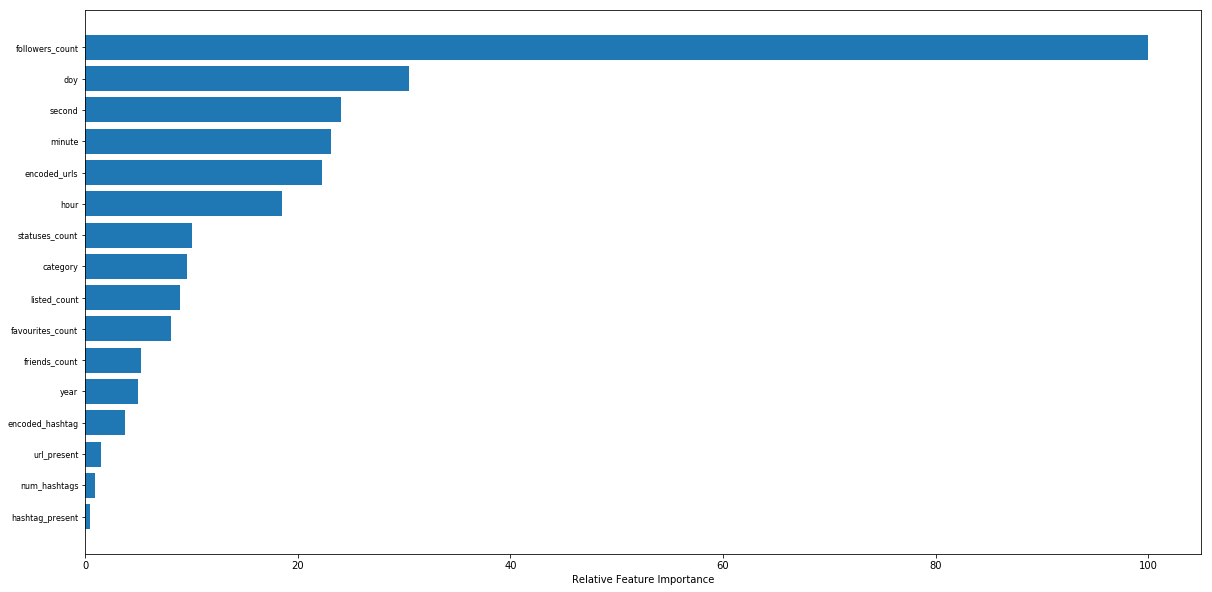

In [239]:
#Top features from Account Features
feature_importance = abs(account_rf.feature_importances_)
feature_importance = 100.0 * (feature_importance / feature_importance.max()) #convert importance to percentage
sorted_idx = np.argsort(feature_importance)[::-1][::-1]
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(20,10))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(pd.DataFrame(account_val).columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')
plt.show()

In [240]:
top_features=pd.DataFrame(account_val).columns[sorted_idx][::-1]
top_features

Index(['followers_count', 'doy', 'second', 'minute', 'encoded_urls', 'hour',
       'statuses_count', 'category', 'listed_count', 'favourites_count',
       'friends_count', 'year', 'encoded_hashtag', 'url_present',
       'num_hashtags', 'hashtag_present'],
      dtype='object')

In [241]:
account_rf=RandomForestRegressor(random_state=42).fit(account_train[['followers_count']], resid_train)

In [242]:
account_rf2s=[RandomForestRegressor(random_state=42).fit(account_train[top_features[:i]], resid_train) for i in range(1, len(top_features)+1)]

In [243]:
account_rf2s_scores=[account_rf2s[i].score(account_val[top_features[:i+1]], resid_val) for i in range(len(top_features))]

In [244]:
account_rf2s_scores

[0.4190172859846527,
 0.3750952504588507,
 0.3835082472523862,
 0.37931798955507623,
 0.34915184592947435,
 0.3654421431335142,
 0.3944493251466963,
 0.39185554822774016,
 0.3984469624635397,
 0.39473539765520926,
 0.40053516881632434,
 0.3980713759816208,
 0.4016114482780222,
 0.3984354352627971,
 0.40279120185483996,
 0.4029358280668458]

Since our model does best with only the first feature, let's only use the follower's count to predict residuals.

In [245]:
account_rf2=RandomForestRegressor(random_state=42).fit(account_train[['followers_count']], resid_train)

In [246]:
account_rf2.score(account_val[['followers_count']], resid_val)

0.4190172859846527

In [247]:
def add_resid_predictions(account_rf=account_rf2,account_val=account_val[['followers_count']], clf=clf, vector_X=tfidf_df_val, threshold=0.5):
    resid_prob_val=account_rf.predict(account_val)
    new_prob=[val[1] for val in clf.predict_proba(vector_X)]+resid_prob_val
    new_prob=pd.Series(new_prob).apply(lambda x: x if x>=0 else 0)
    percent_prob= [round(num*100, 2) for num in new_prob]
    pred_new_prob=[]
    for num in new_prob:
        if num>=threshold: #threshold; default, predict 1 if threshold is over 0.5, 0 if less than 0.5
            pred_new_prob.append(1)
        else:
            pred_new_prob.append(0)
    return [percent_prob, pred_new_prob]
results=add_resid_predictions()
percent_prob=results[0] #percent probability of being ratioed
pred_new_prob=results[1] #predictions (ratio/non-ratio)

In [248]:
percent_prob[:10]

[0.0, 1.2, 71.92, 18.66, 0.0, 74.28, 56.84, 22.96, 10.74, 41.55]

In [249]:
#Probabilities of being ratioed
pred_new_prob[:4]

[0, 0, 1, 0]

In [250]:
y_validate[:4]

1370    0
681     0
2556    1
606     0
Name: ratio_target, dtype: int64

In [251]:
#Predicting with a validation dataset
print("Combined Log Reg+ RF Regression Accuracy:",metrics.accuracy_score(y_validate, pd.Series(pred_new_prob)))
print("Combined Log Reg+ RF Precision:",metrics.precision_score(y_validate, pd.Series(pred_new_prob)))
print("Combined Log Reg+ RF Recall:",metrics.recall_score(y_validate, pd.Series(pred_new_prob)))
print("Combined Log Reg+ RF F1 Score:",metrics.f1_score(y_validate, pd.Series(pred_new_prob)))

Combined Log Reg+ RF Regression Accuracy: 0.8615160349854227
Combined Log Reg+ RF Precision: 0.806930693069307
Combined Log Reg+ RF Recall: 0.9504373177842566
Combined Log Reg+ RF F1 Score: 0.8728246318607765


We were able to improve our model, with a recall >0.9

### GloVe Word Embedding

* https://nlp.stanford.edu/projects/glove/

In [89]:
!pip install gensim

     |████████████████████████████████| 24.2MB 12.4MB/s eta 0:00:01
     |████████████████████████████████| 122kB 58.6MB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-2.1.0-cp36-none-any.whl size=109491 sha256=0304015b207c901d50953b3d4582deef3710d06a0e0b87a76338790e5f33fa0c
  Stored in directory: /home/ec2-user/.cache/pip/wheels/25/6c/db/7dcb26f19fb260c5629af85ed1c8ef9641143444fc7ec1fa08
Successfully built smart-open
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
#Import GloVe using gensim
import gensim.downloader as api
glove_twitter = api.load("glove-twitter-200")

In [ ]:
#If you desire to locally import, instead of using gensim import: 
# def loadGloveModel(File):
#     print("Loading Glove Model")
#     f = open(File,'r')
#     gloveModel = {}
#     for line in f:
#         splitLines = line.split()
#         word = splitLines[0]
#         wordEmbedding = np.array([float(value) for value in splitLines[1:]])
#         gloveModel[word] = wordEmbedding
#     print(len(gloveModel)," words loaded!")
#     return gloveModel

#glove_twitter=loadGloveModel('glove.twitter.27B.200d.txt')

We can use pre-trained GloVe vectors to find similar words:

In [457]:
glove_twitter['hello'][:5]

array([ 0.34683, -0.19612, -0.34923, -0.28158, -0.75627], dtype=float32)

In [253]:
glove_twitter.most_similar('hello')

[('hey', 0.7900470495223999),
 ('hi', 0.7673512101173401),
 ('dear', 0.7181550860404968),
 ('welcome', 0.6986153721809387),
 ('morning', 0.6838774681091309),
 ('goodbye', 0.6520751118659973),
 ('thanks', 0.6399416923522949),
 ('thank', 0.6307862997055054),
 ('yes', 0.6267278790473938),
 ('guys', 0.6202508807182312)]

Let's create a function to assemble our embedded tweet vectors. This takes the average or sum of individual word vectors for each tweet:

In [254]:
def word_to_glove_vector(tweet, size, vectors, aggregation='mean'):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tweet.split():
        try:
            vec += vectors[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if aggregation == 'mean':
        if count != 0:
            vec /= count
        return vec
    elif aggregation == 'sum':
        return vec

In [255]:
from sklearn.preprocessing import scale

In [256]:
#Assemble GloVe vectors, using mean aggregation
train_vecs_glove_mean = scale(np.concatenate([word_to_glove_vector(tweet, 200, glove_twitter,'mean') for tweet in X_train['cleaned_text'].values]))
validation_vecs_glove_mean = scale(np.concatenate([word_to_glove_vector(tweet, 200, glove_twitter,'mean') for tweet in X_validate['cleaned_text'].values]))

In [257]:
g_clf = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
g_clf.fit(train_vecs_glove_mean, y_train)
print(g_clf.score(validation_vecs_glove_mean, y_validate))

0.6880466472303207


In [258]:
from sklearn import metrics
# Predicting with a test dataset
best_predict3=g_clf.predict(validation_vecs_glove_mean)
# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_validate, pd.Series(best_predict3)))
print("Logistic Regression Precision:",metrics.precision_score(y_validate, pd.Series(best_predict3)))
print("Logistic Regression Recall:",metrics.recall_score(y_validate, pd.Series(best_predict3)))
print("Logistic Regression F1 Score:",metrics.f1_score(y_validate, pd.Series(best_predict3)))

Logistic Regression Accuracy: 0.6880466472303207
Logistic Regression Precision: 0.6767123287671233
Logistic Regression Recall: 0.7201166180758017
Logistic Regression F1 Score: 0.6977401129943502


Let's look at feature importance of our tweet vectors:

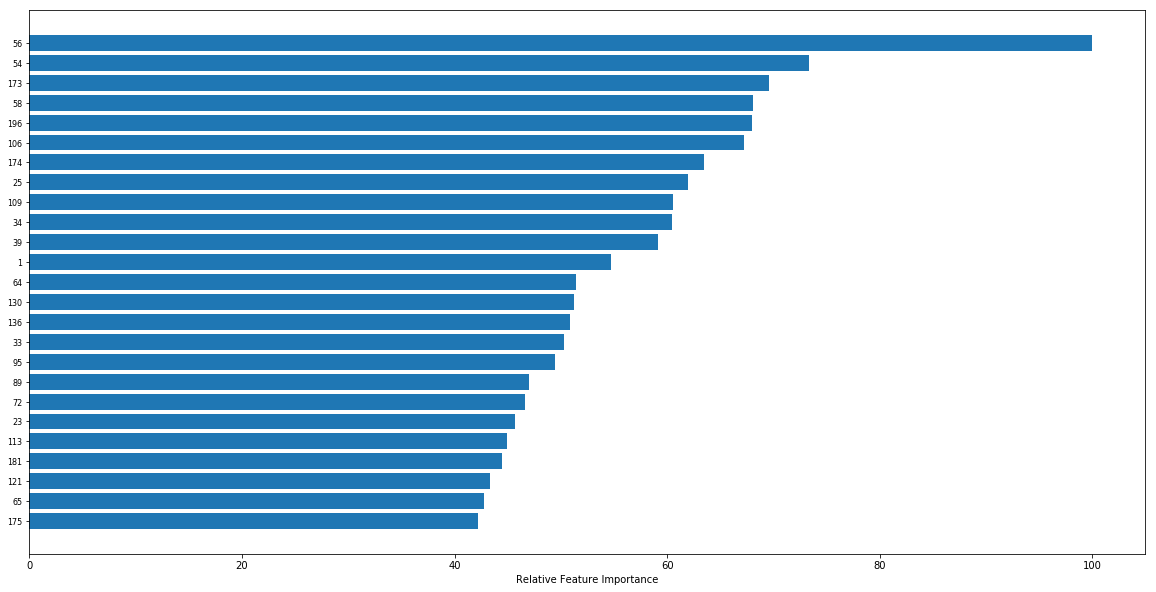

In [259]:
feature_importance = abs(g_clf.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[::-1][:25][::-1] #get top features
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(20,10))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(pd.DataFrame(validation_vecs_glove_mean).columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')
plt.show()

Let's look at top 50 word vectors:

In [260]:
top_word_vectors=np.array(pd.DataFrame(validation_vecs_glove_mean).columns)[sorted_idx][::-1]

In [261]:
top_word_vectors

array([ 56,  54, 173,  58, 196, 106, 174,  25, 109,  34,  39,   1,  64,
       130, 136,  33,  95,  89,  72,  23, 113, 181, 121,  65, 175])

In [262]:
y_validate.index

Int64Index([1370,  681, 2556,  606,  109,  458, 2173,   70,  316,  595,
            ...
            1844, 2041,  174,  732, 2316, 1531,  583, 1611, 2651,  112],
           dtype='int64', length=686)

In [438]:
#pd.DataFrame(validation_vecs_glove_mean, index=y_validate.index)[top_word_vectors]

In [264]:
#concatenate cleaned text, word vectors, and ratio target
top_vec_df= pd.concat([X_validate['cleaned_text'], pd.DataFrame(validation_vecs_glove_mean, index=y_validate.index)[top_word_vectors], pd.DataFrame(y_validate, columns=['ratio_target'])], axis=1)

In [447]:
top_vec_df.iloc[0:].sort_values(by=list(top_word_vectors), ascending=False)

,cleaned_text,56,54,173,58,196,106,174,25,109,...,95,89,72,23,113,181,121,65,175,ratio_target
1253,meredith best,4.349272,2.208589,-0.482417,-2.498051,-0.463766,0.796910,1.560606,0.421011,0.206501,...,1.201170,3.197213,-0.291541,-2.445689,1.272652,-0.029660,2.363885,-0.290016,-0.119471,0
431,final chicagobears win mnf bear chivswas lexus,2.722495,0.568031,0.410438,-0.130273,0.169988,-0.442536,0.471750,-0.876906,-1.217937,...,-1.580717,-0.680166,-2.046563,-1.020003,0.971974,1.635478,-0.361311,0.301293,-0.902279,0
128,ouch,2.677588,5.885329,1.376581,-1.596509,-1.832549,0.008254,-0.973439,-0.144280,1.552321,...,0.474521,-1.580192,0.282402,3.994416,0.951501,3.226037,0.282631,-1.863951,-1.863395,0
609,hero pic stuartbroad,2.676541,0.754401,2.048607,-1.237203,-0.450012,2.079776,3.086033,-0.229401,0.181086,...,0.568286,-0.882753,-0.158613,0.830688,1.623113,0.869567,-0.549065,-1.077391,3.479151,0
1160,huuuuuuuge packer gopackgo,2.651720,1.696724,1.378018,-2.545859,-1.302411,1.059307,1.899658,0.434855,-2.093472,...,-1.211559,-1.816855,-2.067189,-1.724257,1.192765,-0.658346,1.856041,2.218110,-4.900721,0
1711,trump angle fox,2.628856,0.756973,3.079803,2.065640,1.920787,-2.970341,-0.413403,-0.510292,-0.677037,...,2.780740,0.930228,-2.885960,0.001701,-0.682773,0.180544,-0.400482,0.336356,1.391999,1
2354,john f kennedy,2.618670,-2.023177,0.387635,1.275881,1.329802,-0.465186,2.199252,-2.394516,1.937830,...,0.066700,1.758941,0.154891,1.145316,-1.090348,-3.130079,0.025521,-1.416605,-0.392256,1
269,giant signing rb dion lewis mikegarafolo,2.588362,-1.177672,2.418893,2.160215,-0.992116,0.100359,1.663524,0.162412,-1.818514,...,1.400935,0.342736,-1.540872,-2.935334,0.398825,-2.014833,-0.300847,-0.099555,0.956861,0
973,musician played violin undergoing brain surgery,2.521290,0.704675,-1.792583,1.007521,0.913866,3.534015,1.849270,0.861639,0.035972,...,1.152796,-0.138906,1.319507,-0.957589,-0.116446,1.149130,-0.680762,-0.895402,-0.603449,0
63,bob hoskins phenomenal job movie time favorite...,2.426408,0.171031,0.407654,1.062462,0.148224,0.380006,0.456501,-0.194947,-0.832997,...,1.828993,0.137600,-1.437418,-0.014777,0.303741,-0.784591,0.806345,-1.035905,-0.045288,0


In [271]:
import seaborn as sns

In [272]:
corr_df=top_vec_df.corr()
corr_df.head()

,56,54,173,58,196,106,174,25,109,34,...,95,89,72,23,113,181,121,65,175,ratio_target
56,1.000000,0.034647,0.236218,-0.064727,0.091337,-0.126312,0.266634,-0.265632,0.050650,-0.067108,...,0.019798,0.101047,0.005102,0.024308,0.088988,-0.188643,0.243316,0.002808,-0.003293,-0.057804
54,0.034647,1.000000,-0.116966,-0.012565,-0.196306,0.046050,-0.072581,-0.124078,-0.118982,-0.024798,...,-0.154720,-0.049497,0.027857,0.045584,0.094147,-0.225406,0.045375,-0.040248,0.217242,-0.135121
173,0.236218,-0.116966,1.000000,0.102246,0.390365,-0.205299,0.216196,-0.206917,0.004208,-0.007429,...,0.221035,-0.045684,-0.180703,-0.071382,-0.009264,-0.038853,0.033638,0.020381,-0.061678,0.173118
58,-0.064727,-0.012565,0.102246,1.000000,0.016897,-0.075245,0.067792,-0.074176,-0.023305,-0.033133,...,0.064787,-0.058417,0.141680,0.098805,0.055037,-0.077297,-0.025546,-0.077110,0.098269,0.062143
196,0.091337,-0.196306,0.390365,0.016897,1.000000,-0.043485,0.235153,0.117643,0.066499,-0.001901,...,0.039406,0.162276,-0.194277,-0.044674,-0.121805,0.005105,-0.017517,0.133763,-0.155971,0.184216


In [273]:
corr_df.sort_values(by='ratio_target', ascending=False).head()

,56,54,173,58,196,106,174,25,109,34,...,95,89,72,23,113,181,121,65,175,ratio_target
ratio_target,-0.057804,-0.135121,0.173118,0.062143,0.184216,-0.191268,0.086538,0.039021,0.082763,0.051695,...,0.036310,-0.023246,0.030899,0.047655,-0.105564,0.004701,0.073980,0.093969,0.039473,1.000000
196,0.091337,-0.196306,0.390365,0.016897,1.000000,-0.043485,0.235153,0.117643,0.066499,-0.001901,...,0.039406,0.162276,-0.194277,-0.044674,-0.121805,0.005105,-0.017517,0.133763,-0.155971,0.184216
173,0.236218,-0.116966,1.000000,0.102246,0.390365,-0.205299,0.216196,-0.206917,0.004208,-0.007429,...,0.221035,-0.045684,-0.180703,-0.071382,-0.009264,-0.038853,0.033638,0.020381,-0.061678,0.173118
64,-0.182043,0.021050,0.009939,0.150091,0.116488,-0.070909,-0.070843,0.067890,-0.069715,-0.087004,...,-0.002697,0.088155,0.202990,0.201327,-0.060539,-0.021137,0.131449,0.081398,0.096254,0.145431
136,0.038380,-0.069947,0.220918,0.024134,0.275071,0.072312,0.014664,0.033149,-0.028120,-0.077006,...,0.073764,0.046500,-0.147017,-0.127313,-0.068278,-0.050541,0.101457,0.129073,-0.177655,0.119892


In [455]:
corr_df[(corr_df.sort_values(by='ratio_target', ascending=False)['ratio_target']>0)]

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,56,54,173,58,196,106,174,25,109,34,...,95,89,72,23,113,181,121,65,175,ratio_target
173,0.236218,-0.116966,1.000000,0.102246,0.390365,-0.205299,0.216196,-0.206917,0.004208,-0.007429,...,0.221035,-0.045684,-0.180703,-0.071382,-0.009264,-0.038853,0.033638,0.020381,-0.061678,0.173118
58,-0.064727,-0.012565,0.102246,1.000000,0.016897,-0.075245,0.067792,-0.074176,-0.023305,-0.033133,...,0.064787,-0.058417,0.141680,0.098805,0.055037,-0.077297,-0.025546,-0.077110,0.098269,0.062143
196,0.091337,-0.196306,0.390365,0.016897,1.000000,-0.043485,0.235153,0.117643,0.066499,-0.001901,...,0.039406,0.162276,-0.194277,-0.044674,-0.121805,0.005105,-0.017517,0.133763,-0.155971,0.184216
174,0.266634,-0.072581,0.216196,0.067792,0.235153,-0.075219,1.000000,-0.232886,0.088660,0.012205,...,-0.007787,-0.012676,-0.147260,-0.042205,0.003882,-0.127864,0.062631,0.044196,-0.056048,0.086538
25,-0.265632,-0.124078,-0.206917,-0.074176,0.117643,0.286651,-0.232886,1.000000,-0.003370,-0.158084,...,-0.144493,0.051044,-0.001859,-0.068926,-0.050569,0.291710,-0.130062,0.102131,-0.197409,0.039021
109,0.050650,-0.118982,0.004208,-0.023305,0.066499,-0.037560,0.088660,-0.003370,1.000000,-0.049418,...,-0.055299,-0.071364,0.060933,-0.013839,0.131734,0.078748,0.046982,-0.068086,0.016299,0.082763
34,-0.067108,-0.024798,-0.007429,-0.033133,-0.001901,-0.257102,0.012205,-0.158084,-0.049418,1.000000,...,-0.049658,-0.142012,0.122212,0.128209,-0.090583,-0.102521,0.057505,0.207536,0.129819,0.051695
1,-0.039265,0.037659,0.131853,0.013083,0.130208,-0.076648,0.141073,-0.151908,-0.052501,0.056012,...,-0.050097,-0.124086,0.041630,-0.061390,0.067351,-0.200744,0.098887,0.084805,0.128297,0.022725
64,-0.182043,0.021050,0.009939,0.150091,0.116488,-0.070909,-0.070843,0.067890,-0.069715,-0.087004,...,-0.002697,0.088155,0.202990,0.201327,-0.060539,-0.021137,0.131449,0.081398,0.096254,0.145431
136,0.038380,-0.069947,0.220918,0.024134,0.275071,0.072312,0.014664,0.033149,-0.028120,-0.077006,...,0.073764,0.046500,-0.147017,-0.127313,-0.068278,-0.050541,0.101457,0.129073,-0.177655,0.119892


In [448]:
#Word vectors that are positively correlated with ratios
pos_corr_df=corr_df[(corr_df.sort_values(by='ratio_target', ascending=False)['ratio_target']>0)]

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


In [454]:
pos_columns=list(pos_corr_df.columns.drop('ratio_target'))

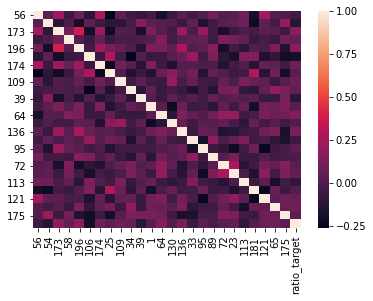

In [450]:
#pearson correlation
sns.heatmap(top_vec_df.corr())

In [278]:
top_vec_df[['cleaned_text']+pos_columns]

,cleaned_text,56,54,173,58,196,106,174,25,109,...,33,95,89,72,23,113,181,121,65,175
1370,thanks sinitta,-0.327036,0.703040,-1.060971,0.416894,-1.138334,-0.543295,-0.597278,-0.224542,0.321787,...,2.135393,0.155799,0.478717,0.259838,2.522986,1.490409,-2.804368,1.956971,1.622668,-0.719572
681,clever dick compliment clever bit dick yes wan...,-0.270409,0.879249,0.391461,-0.700112,-0.075037,-0.669132,-0.604815,1.306892,-0.275665,...,-0.414868,0.191215,0.416738,-0.313567,0.090045,-0.611651,1.205065,-0.572676,-0.746614,0.174565
2556,year s mentalhealthawarenessmonth reminds impo...,-0.356423,0.028829,-0.686738,-0.254278,-1.167229,0.331985,0.028519,0.541302,-0.840009,...,1.070480,-1.203533,-0.656069,0.599086,0.272197,0.211862,1.292286,0.749829,0.355051,1.121518
606,latest model s slightly faster,0.035519,-1.365376,-1.881150,-0.783066,-0.326823,-0.325997,-0.473178,0.231807,0.613948,...,-2.650378,1.059099,-0.792380,-0.166576,0.729020,1.744524,0.661835,2.035334,0.636281,1.350346
109,markingram went beastmode yard balvsmia cbs nf...,-0.398680,0.554437,0.129211,-0.553411,-0.732338,-1.123592,0.496842,-1.087544,-1.757805,...,-2.064769,1.117709,-1.668768,-0.308496,-0.493966,0.816854,0.288473,0.142270,-1.176346,0.675292
458,update flight log prove alleged epstein victim...,0.246279,-0.597250,0.213336,-2.070308,-1.022391,0.346715,-0.417152,0.247039,-0.712576,...,-1.902993,0.434390,-1.187346,-0.050489,0.284662,-0.425383,-1.095350,0.517934,0.581859,0.466141
2173,triggered,0.575804,4.515708,-2.154540,-0.893207,2.154707,-0.077209,1.313891,0.508705,-1.344490,...,-2.941648,-2.811993,3.072310,1.460280,-3.119769,-2.577164,-1.359914,1.164136,2.758358,4.322824
70,ironically don t understand said,-0.779595,-0.235914,-0.899551,-0.412677,0.123663,1.577289,-0.046765,-0.990600,-1.351145,...,-0.083549,-0.735442,-0.162883,0.514384,-0.584277,-1.714711,-0.967126,-0.096511,-0.907376,0.584628
316,happy b day mamma dear god shared best laugh k...,-0.506623,1.684483,-0.631344,0.234228,-0.793437,0.515554,0.113900,-0.153876,0.678206,...,1.572945,-1.416487,0.644951,-0.102325,0.768887,0.093336,-1.189406,0.134762,-1.509241,0.586801
595,thanks pr push jenny,0.101647,1.625901,-0.562855,0.738240,0.773077,0.363770,-2.434757,-1.190086,-0.334481,...,0.350125,-1.847551,-1.325777,-0.152446,0.737457,0.956980,-0.724701,0.594997,-0.392680,-0.772947


In [279]:
vec_pos_train=pd.DataFrame(train_vecs_glove_mean, index=y_train.index)[top_word_vectors]
vec_pos_val=pd.DataFrame(validation_vecs_glove_mean, index=y_validate.index)[top_word_vectors]

In [280]:
g_clf2 = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
g_clf2.fit(vec_pos_train, y_train)
print(g_clf2.score(vec_pos_val, y_validate))

0.6559766763848397


In [281]:
from sklearn import metrics
# Predicting with a test dataset
best_predict4=g_clf2.predict(vec_pos_val)
# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_validate, pd.Series(best_predict4)))
print("Logistic Regression Precision:",metrics.precision_score(y_validate, pd.Series(best_predict4)))
print("Logistic Regression Recall:",metrics.recall_score(y_validate, pd.Series(best_predict4)))
print("Logistic Regression F1 Score:",metrics.f1_score(y_validate, pd.Series(best_predict4)))

Logistic Regression Accuracy: 0.6559766763848397
Logistic Regression Precision: 0.6481994459833795
Logistic Regression Recall: 0.6822157434402333
Logistic Regression F1 Score: 0.6647727272727273


Let's re-analyze with user account information in combination with all of our GloVe vectors:

In [282]:
glove_train_df=pd.DataFrame(train_vecs_glove_mean, index=y_train.index)
glove_val_df=pd.DataFrame(validation_vecs_glove_mean, index=y_validate.index)
glove_train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
1762,-0.427556,-0.928468,-1.180885,-0.516396,0.324118,0.600376,0.168656,-0.861987,-0.088025,-0.798605,...,0.606654,-0.434391,0.459489,0.447639,0.483339,0.234807,0.354496,0.128868,-0.724611,-0.186644
87,-0.823506,0.622139,-0.777456,1.366398,-0.166485,1.008802,-0.107452,-0.615417,1.439010,0.907569,...,0.725251,-1.181513,-0.043355,-0.612681,1.002366,0.390724,0.672151,0.297857,1.350899,-0.216384
1227,0.619379,0.445437,-0.296363,-0.440788,0.489161,0.604779,-0.363635,0.712748,-0.980736,-0.576177,...,0.494999,-0.318834,0.121738,-0.389299,-0.013628,-0.239849,0.615472,-0.282047,-0.186860,0.587325
2168,-0.249662,-0.207845,0.400212,0.883732,-0.266762,0.030640,0.632613,0.021408,-0.010909,-0.741831,...,0.494470,0.392704,-0.721591,0.608333,-0.807157,0.398312,1.227357,1.522222,-0.305917,-1.698510
1650,0.215796,0.131512,0.808874,-0.121784,0.660809,-0.232826,0.958803,0.268337,0.318188,-0.383876,...,0.604952,-0.671602,-0.829123,-0.012562,-0.645232,-0.649375,0.478450,1.078327,0.900206,-0.509166


In [283]:
np.array(glove_train_df.loc[860])

array([ 4.28024346,  3.24634376,  1.4048253 ,  1.10218697, -5.45926752,
       -0.13121765, -1.44555629,  0.91331833,  1.58433154,  2.42755175,
       -1.97610939,  2.09452427,  3.74353271, -0.343541  , -2.92618308,
        3.33820839,  5.82317472,  2.8801379 , -3.35504936, -1.72041281,
        0.58946643, -0.01156987,  1.15864546,  1.9727185 ,  3.36065453,
        0.27866987,  0.17352606,  1.45607024, -5.76718031, -0.22991339,
        0.72677083, -0.02679011,  0.3814504 ,  0.27964779, -0.60128993,
       -0.46565454,  1.54998401,  3.07258518,  2.71154884, -2.26172865,
       -1.99899074,  2.51609737, -0.94187573, -1.6505883 , -0.20536829,
       -4.17042088,  4.76515015,  0.91720419,  0.89149287,  0.82802793,
        2.5939853 , -4.33838691, -0.41001211,  0.83890151,  1.86821443,
       -9.03239837, -3.44366197,  2.0841264 , -0.3688535 , -0.24657225,
       -4.37002628, -0.05001589,  1.04440104,  1.84373417, -0.92523699,
        2.02893634,  1.65470494, -0.87055547,  0.6549613 ,  0.16

In [284]:
#For gensim, look at most similar words, given a word vector:
glove_twitter.similar_by_vector(np.array(glove_train_df.loc[1490]), topn=10, restrict_vocab=None)

[('bummin', 0.7668828964233398),
 ('scrubbin', 0.5931721925735474),
 ('bernie', 0.562293529510498),
 ('bumming', 0.5252249836921692),
 ('swagging', 0.44920313358306885),
 ('clownin', 0.43521636724472046),
 ('simpin', 0.4261730909347534),
 ('laggin', 0.424247145652771),
 ('swaggin', 0.4233991503715515),
 ('fonkin', 0.419587641954422)]

In [285]:
X_train.loc[1490]['cleaned_text']

'bernie bummin'

In [364]:
glove_merged_train_df=pd.concat([scaled_features_under.loc[X_train.index], glove_train_df], axis=1)
glove_merged_val_df=pd.concat([scaled_features_under.loc[X_validate.index], glove_val_df], axis=1)

In [365]:
glove_merged_train_df.head()

,followers_count,friends_count,listed_count,favourites_count,statuses_count,doy,year,hour,minute,second,...,190,191,192,193,194,195,196,197,198,199
1762,-0.444248,0.286484,-0.187917,3.068190,1.248937,-0.694078,-0.747132,-0.376054,1.457163,-1.561464,...,0.606654,-0.434391,0.459489,0.447639,0.483339,0.234807,0.354496,0.128868,-0.724611,-0.186644
87,-0.019616,-0.033758,-0.024833,-0.357879,0.477973,-1.435258,-0.747132,0.990871,-0.796376,-0.999998,...,0.725251,-1.181513,-0.043355,-0.612681,1.002366,0.390724,0.672151,0.297857,1.350899,-0.216384
1227,4.573057,-0.161501,4.147256,-0.357905,-0.560831,0.778530,-0.747132,0.717486,-1.528777,-0.438533,...,0.494999,-0.318834,0.121738,-0.389299,-0.013628,-0.239849,0.615472,-0.282047,-0.186860,0.587325
2168,-0.404076,-0.156979,-0.392254,-0.345399,0.389697,0.593235,-0.747132,-1.879672,1.569840,0.122933,...,0.494470,0.392704,-0.721591,0.608333,-0.807157,0.398312,1.227357,1.522222,-0.305917,-1.698510
1650,-0.444248,0.286484,-0.187917,3.068190,1.248937,1.568472,-0.747132,-0.376054,1.513501,-1.168438,...,0.604952,-0.671602,-0.829123,-0.012562,-0.645232,-0.649375,0.478450,1.078327,0.900206,-0.509166


In [380]:
list(glove_merged_train_df.columns)

['followers_count',
 'friends_count',
 'listed_count',
 'favourites_count',
 'statuses_count',
 'doy',
 'year',
 'hour',
 'minute',
 'second',
 'encoded_urls',
 'encoded_hashtag',
 'num_hashtags',
 'url_present',
 'hashtag_present',
 'category',
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,


In [381]:
g_clf3 = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
g_clf3.fit(glove_merged_train_df, y_train)
print(g_clf3.score(glove_merged_val_df, y_validate))

0.8061224489795918


In [382]:
# Predicting with a test dataset
best_predict5=g_clf3.predict(glove_merged_val_df)
# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_validate, pd.Series(best_predict5)))
print("Logistic Regression Precision:",metrics.precision_score(y_validate, pd.Series(best_predict5)))
print("Logistic Regression Recall:",metrics.recall_score(y_validate, pd.Series(best_predict5)))
print("Logistic Regression F1 Score:",metrics.f1_score(y_validate, pd.Series(best_predict5)))

Logistic Regression Accuracy: 0.8061224489795918
Logistic Regression Precision: 0.7792553191489362
Logistic Regression Recall: 0.8542274052478134
Logistic Regression F1 Score: 0.8150208623087621


Let's graph the ROC/AUC curve:

In [383]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.881


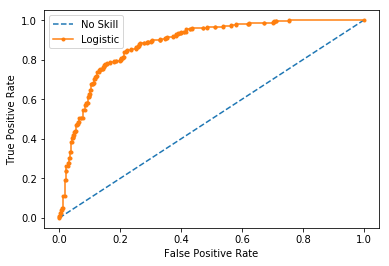

In [384]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_validate))]
# predict probabilities
lr_probs = g_clf3.predict_proba(glove_merged_val_df)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_validate, ns_probs)
lr_auc = roc_auc_score(y_validate, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_validate, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_validate, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Let's look at the most important features for the GloVe vectors/account info:

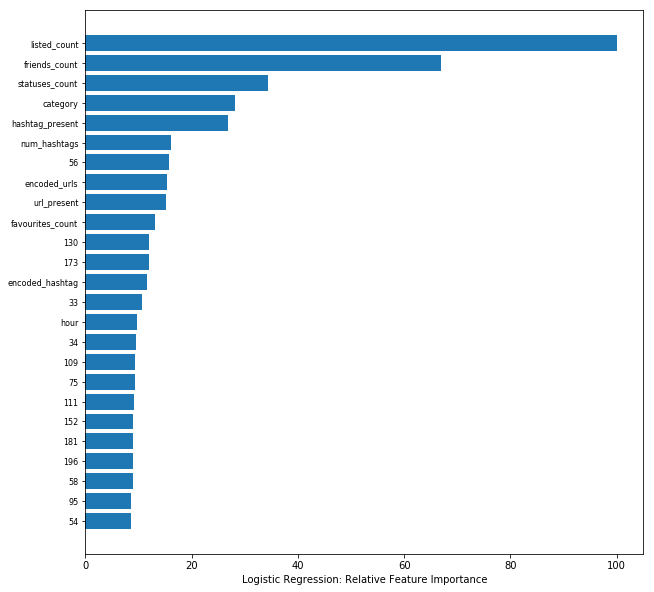

In [433]:
feature_importance = abs(g_clf3.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[::-1][:25][::-1]
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(10,10))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(glove_merged_val_df.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Logistic Regression: Relative Feature Importance')
plt.show()

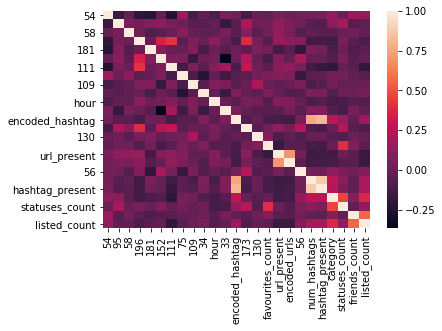

In [434]:
top_25=(glove_merged_val_df.columns)[sorted_idx]
#pearson correlation
sns.heatmap(glove_merged_val_df[top_25].corr())

In [435]:
top_25

Index([                54,                 95,                 58,
                      196,                181,                152,
                      111,                 75,                109,
                       34,             'hour',                 33,
        'encoded_hashtag',                173,                130,
       'favourites_count',      'url_present',     'encoded_urls',
                       56,     'num_hashtags',  'hashtag_present',
               'category',   'statuses_count',    'friends_count',
           'listed_count'],
      dtype='object')

In [437]:
g_clf4 = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
g_clf4.fit(glove_merged_train_df[top_25], y_train)
print(g_clf4.score(glove_merged_val_df[top_25], y_validate))

0.8323615160349854


Interestingly, the number of public lists and other account information are amongst the most important features. 

Field information (as defined by Twitter):
* followers_count: The number of followers this account currently has. Under certain conditions of duress, this field will temporarily indicate “0”. Example:
* friends_count: The number of users this account is following (AKA their “followings”). 
* listed_count: The number of public lists that this user is a member of. 
* favourites_count: The number of Tweets this user has liked in the account’s lifetime. British spelling used in the field name for historical reasons.
* statuses_count: The number of Tweets (including retweets) issued by the user.

In [307]:
glove_resid_train=residuals(clf=g_clf, X=glove_train_df, y=y_train)
glove_resid_val=residuals(clf=g_clf, X=glove_val_df, y=y_validate)

In [333]:
glove_account_rf=RandomForestRegressor(random_state=42).fit(account_train[['followers_count']], glove_resid_train)

In [334]:
glove_account_rf.score(account_val[['followers_count']], glove_resid_val)

0.2991546135476085

In [339]:
glove_results=add_resid_predictions(account_rf=glove_account_rf,account_val=account_val[['followers_count']], clf=g_clf, vector_X=glove_val_df, threshold=0.4)
glove_percent_prob=glove_results[0] #percent probability of being ratioed
glove_pred_new_prob=glove_results[1] #predictions (ratio/non-ratio)

In [340]:
#Predicting with a validation dataset
print("Combined Log Reg+ RF Regression Accuracy:",metrics.accuracy_score(y_validate, pd.Series(glove_pred_new_prob)))
print("Combined Log Reg+ RF Precision:",metrics.precision_score(y_validate, pd.Series(glove_pred_new_prob)))
print("Combined Log Reg+ RF Recall:",metrics.recall_score(y_validate, pd.Series(glove_pred_new_prob)))
print("Combined Log Reg+ RF F1 Score:",metrics.f1_score(y_validate, pd.Series(glove_pred_new_prob)))

Combined Log Reg+ RF Regression Accuracy: 0.8177842565597667
Combined Log Reg+ RF Precision: 0.7698019801980198
Combined Log Reg+ RF Recall: 0.9067055393586005
Combined Log Reg+ RF F1 Score: 0.8326639892904952


Let's use GridSearch to see if we can improve upon the model

In [458]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [459]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

solver=['liblinear','saga']

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty, solver=solver)


# Create grid search using 5-fold cross validation
clf_gs1 = GridSearchCV(LogisticRegression(max_iter=5000), hyperparameters, cv=5, verbose=0)

best_clf2 = clf_gs1.fit(glove_merged_train_df, y_train)

In [460]:
# Create first pipeline for base without reducing features.

# g_clf3 = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
# g_clf3.fit(glove_merged_train_df, y_train)
# print(g_clf3.score(glove_merged_val_df, y_validate))


pipe = Pipeline([('classifier' , RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))}
]

# Create grid search object

clf_gs = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf_gs.fit(glove_merged_train_df, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.4min finished


In [461]:
best_clf 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression()],
                          'classifier__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1....59970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                          'classifier__penalty': ['l1', 'l2'],
                          'classifier__solver': ['liblinear']},
                         {'classifier': [RandomForestClassifier(max_features=21,
                                                                n_estimators=30)],
                          'classifier__max_features': [6, 11, 16, 21, 26, 31],
                          'class

In [462]:
best_clf.score(glove_merged_val_df, y_validate) 

0.8498542274052479

In [463]:
best_clf.best_params_

{'classifier': RandomForestClassifier(max_features=21, n_estimators=30),
 'classifier__max_features': 21,
 'classifier__n_estimators': 30}

In [464]:
rf=RandomForestClassifier(n_estimators= 60, max_features=31).fit(glove_merged_train_df, y_train)

In [465]:
rf.score(glove_merged_val_df, y_validate)

0.8527696793002916

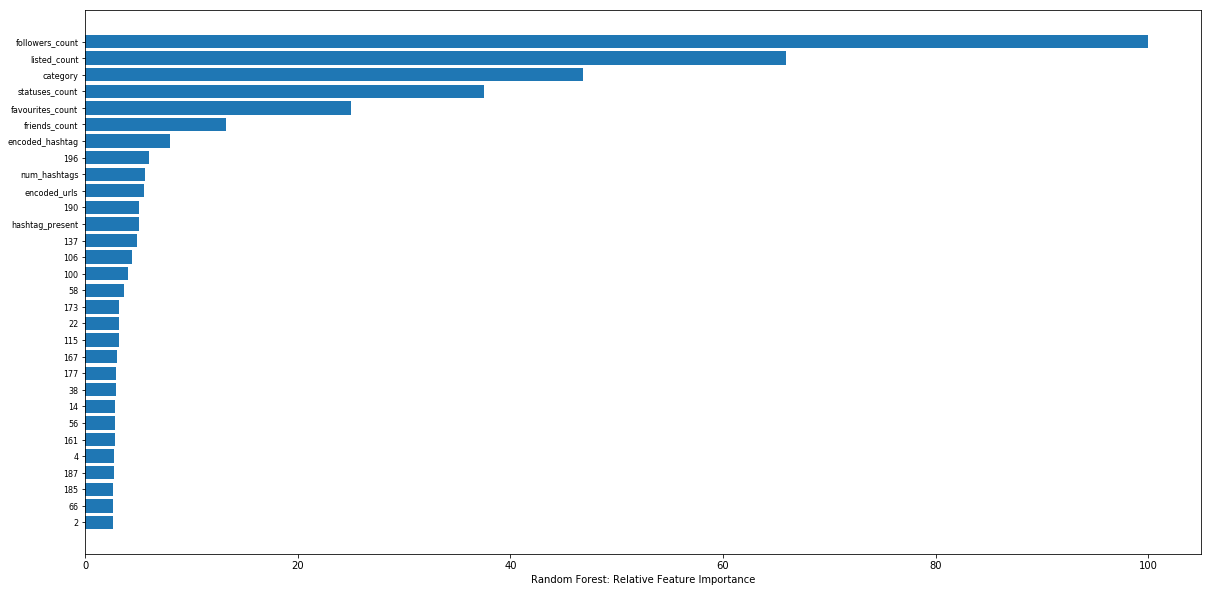

In [466]:
feature_importance=rf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[::-1][:30][::-1]
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(20,10))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(glove_merged_val_df.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Random Forest: Relative Feature Importance')
plt.show()

In [467]:
sorted_idx = np.argsort(feature_importance)[::-1][:50][::-1]
top_rf_features=np.array(glove_merged_val_df.columns)[sorted_idx]

In [468]:
rf2=RandomForestClassifier(n_estimators= 60, max_features=31).fit(glove_merged_train_df[top_rf_features], y_train)

In [469]:
rf2.score(glove_merged_val_df[top_rf_features], y_validate)

0.8498542274052479

In [470]:
# Predicting with a test dataset
best_predict_rf2=rf2.predict(glove_merged_val_df[top_rf_features])
# Model Accuracy
print("Random Forest Accuracy:",metrics.accuracy_score(y_validate, pd.Series(best_predict_rf2)))
print("Random Forest Precision:",metrics.precision_score(y_validate, pd.Series(best_predict_rf2)))
print("Random Forest Recall:",metrics.recall_score(y_validate, pd.Series(best_predict_rf2)))

Random Forest Accuracy: 0.8498542274052479
Random Forest Precision: 0.8225806451612904
Random Forest Recall: 0.892128279883382


In [471]:
##Let's use eli5 to look at feature importance on the smaller features
!pip install eli5

     |████████████████████████████████| 112kB 10.6MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [472]:
#eli5 feature importance
from eli5.sklearn import PermutationImportance
import eli5

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [473]:
perm = PermutationImportance(rf2).fit(glove_merged_val_df[top_rf_features], y_validate)
exp_df = eli5.explain_weights_df(perm, feature_names = list(glove_merged_val_df[top_rf_features].columns))

In [474]:
exp_df

,feature,weight,std
0,followers_count,1.935860e-01,0.015188
1,category,4.693878e-02,0.004826
2,listed_count,1.865889e-02,0.004913
3,statuses_count,3.206997e-03,0.001700
4,68,2.915452e-03,0.000922
5,21,2.332362e-03,0.002857
6,56,2.332362e-03,0.002182
7,140,1.749271e-03,0.001700
8,39,1.457726e-03,0.000000
9,encoded_urls,1.457726e-03,0.002062


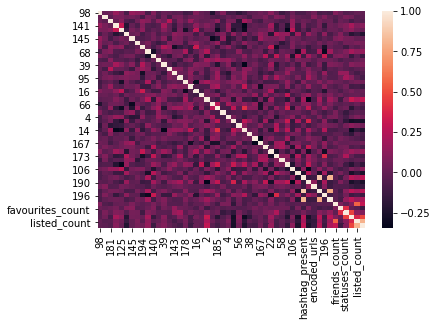

In [475]:
#pearson correlation
sns.heatmap(glove_merged_val_df[top_rf_features].corr())

Visualize tweets using T-SNE

In [476]:
#t-SNE
from sklearn.manifold import TSNE  #Import the t-SNE algorithm

In [477]:
X_embedded = TSNE(n_components=2).fit_transform(glove_merged_val_df[top_rf_features])
X_embedded.shape

(686, 2)

In [478]:
glove_merged_val_df[top_rf_features].head()

,98,doy,181,141,125,94,145,21,194,68,...,encoded_urls,num_hashtags,196,encoded_hashtag,friends_count,favourites_count,statuses_count,category,listed_count,followers_count
1370,-2.051534,0.105616,-2.804368,-2.969167,-0.239925,4.560656,0.594083,4.311747,0.179482,1.665132,...,1.521286,-0.437681,-1.138334,-0.415020,-0.033758,-0.357879,0.477973,2,-0.024833,-0.019616
681,0.546447,-0.596554,1.205065,0.145355,0.957742,0.071739,0.943811,0.168522,0.961655,-0.886731,...,1.466382,-0.437681,-0.075037,-0.415020,-0.033758,-0.357879,0.477973,2,-0.024833,-0.019616
2556,-0.309693,-0.294231,1.292286,-0.738611,-0.388287,0.004753,-0.335964,-0.152912,0.881122,-0.244084,...,1.291152,1.148841,-1.167229,2.029749,-0.157634,-0.357387,-1.212560,1,-0.756258,-0.486038
606,-0.067740,-0.255221,0.661835,0.734438,-0.177907,1.261583,-0.148597,-0.299713,-0.140095,1.769236,...,-0.977065,-0.437681,-0.326823,-0.415020,-0.158683,-0.282943,-1.079895,4,1.514799,1.727294
109,0.652307,0.934568,0.288473,1.212000,-1.146554,-1.193685,-0.531062,-0.006215,-0.357845,2.135707,...,-0.340558,1.148841,-0.732338,-0.068478,0.011335,-0.335095,1.381189,4,1.256784,1.075090


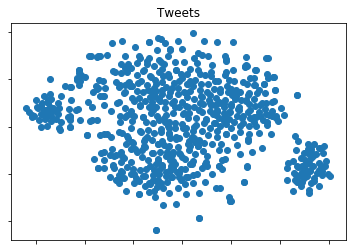

In [481]:
#Plot the t-SNE output
fig, ax = plt.subplots()
ax.plot(X_embedded [:, 0], X_embedded [:, 1], 'o')
ax.set_title('Tweets')
ax.set_yticklabels([]) #Hide ticks
ax.set_xticklabels([]) #Hide ticks
plt.show()

In [ ]:
#Fins similar words given a vector
glove_twitter.similar_by_vector(np.array(glove_val_df.loc[1370]), topn=5, restrict_vocab=None)

### Vader Sentiment Analysis

In [168]:
!pip install vaderSentiment

     |████████████████████████████████| 133kB 11.1MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [294]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def vader_sentiment(texts=df['cleaned_text']):
    vader_scores=[]
    sentences = texts
    analyzer = SentimentIntensityAnalyzer()
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        vader_scores.append(vs)
        #print("{:-<65} {}".format(sentence, str(vs)))
    
    return vader_scores

In [295]:
vader_scores_train=vader_sentiment(texts=X_train['cleaned_text'])

In [296]:
vader_df_train=pd.DataFrame({"sentiments":vader_scores_train, 'ratio_target':y_train}, index=X_train.index)

In [297]:
vader_df_train.head()

,sentiments,ratio_target
1762,"{'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'comp...",1
87,"{'neg': 0.288, 'neu': 0.468, 'pos': 0.245, 'co...",0
1227,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0
2168,"{'neg': 0.573, 'neu': 0.427, 'pos': 0.0, 'comp...",1
1650,"{'neg': 0.056, 'neu': 0.662, 'pos': 0.281, 'co...",1


In [298]:
vader_df_train = pd.concat([vader_df_train.drop(['sentiments'], axis=1), vader_df_train['sentiments'].apply(pd.Series)], axis=1)

In [299]:
vader_df_train.head()

,ratio_target,neg,neu,pos,compound
1762,1,0.000,0.625,0.375,0.7351
87,0,0.288,0.468,0.245,-0.4939
1227,0,0.000,1.000,0.000,0.0000
2168,1,0.573,0.427,0.000,-0.9246
1650,1,0.056,0.662,0.281,0.7783


In [300]:
vader_df_train.ratio_target.unique()

array([1, 0])

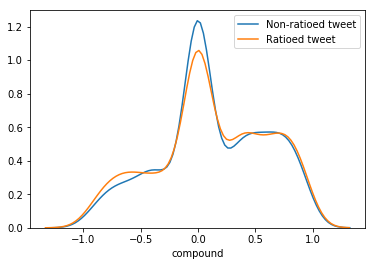

In [301]:
# plot sentiment distribution for positive and negative reviews

import seaborn as sns

for x in [0, 1]:
    subset = vader_df_train[vader_df_train['ratio_target']== x]
    #subset = vader_df.loc[train_idx][vader_df.loc[train_idx]['ratio_target']== x]
    # Draw the density plot
    if x == 0:
        label = "Non-ratioed tweet"
    else:
        label = "Ratioed tweet"
    sns.distplot(subset['compound'], hist = False, label = label)

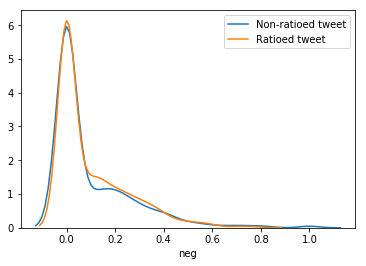

In [302]:
# plot sentiment distribution for positive and negative reviews

import seaborn as sns

for x in [0, 1]:
    subset = vader_df_train[vader_df_train['ratio_target']== x]
    #subset = vader_df.loc[train_idx][vader_df.loc[train_idx]['ratio_target']== x]
    # Draw the density plot
    if x == 0:
        label = "Non-ratioed tweet"
    else:
        label = "Ratioed tweet"
    sns.distplot(subset['neg'], hist = False, label = label)

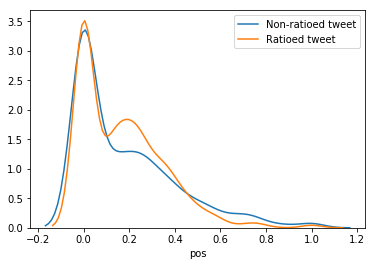

In [303]:
# plot sentiment distribution for positive and negative reviews

import seaborn as sns

for x in [0, 1]:
    subset = vader_df_train[vader_df_train['ratio_target']== x]
    #subset = vader_df.loc[train_idx][vader_df.loc[train_idx]['ratio_target']== x]
    # Draw the density plot
    if x == 0:
        label = "Non-ratioed tweet"
    else:
        label = "Ratioed tweet"
    sns.distplot(subset['pos'], hist = False, label = label)

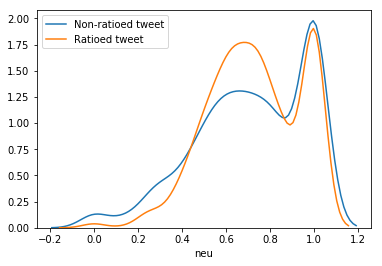

In [304]:
# plot sentiment distribution for positive and negative reviews

import seaborn as sns

for x in [0, 1]:
    subset = vader_df_train[vader_df_train['ratio_target']== x]
    #subset = vader_df.loc[train_idx][vader_df.loc[train_idx]['ratio_target']== x]
    # Draw the density plot
    if x == 0:
        label = "Non-ratioed tweet"
    else:
        label = "Ratioed tweet"
    sns.distplot(subset['neu'], hist = False, label = label)

* Might need to re-think strategy on time-dependency (i.e. make training data only early/2019, and validate on more recent data/2020). However, due to the low frequency of ratios in dataset, just used random/undersampling strategy, with equal distribution of ratios in training and validation data 